# Teste ANOVA para o mercado financeiro

O objetivo dessa tarefa é fazer um teste de média entre as ações dentro da carteira montada no exercício de análise do mercado financeiro. Os detalhes dessa análise podem ser vistos aqui: https://github.com/demetriusjube/ppca-aedi/tree/master/mercado-financeiro.

Como definido lá, montamos uma carteira com as empresas que compõem o FAANG (Facebook, Amazon, Apple, Netflix e Google), juntamente com a Tesla, e utilizamos o índice NASDAQ para comparação. Esperamos, assim, ver se há influência entre esses papeis e o comportamento do NASDAQ. 

Os identificadores das empresas e do índice são os seguintes:
* Meta (antigo Facebook) - META
* Amazon - AMZN
* Apple - AAPL
* Netflix - NFLX
* Google - GOOGL
* Tesla - TSLA
* NASDAQ - ^NDX

## Montagem dos dados para realização do teste

O primeiro passo para isso é montar os dados da carteira. Os detalhes dessa montagem estão descritos no trabalho anterior, e não serão replicados aqui. O resultado final que buscamos é uma relação entre a taxa de retorno médio das ações e o retorno do índice NASDAQ, pois essa comparação que será alvo da ANOVA.

Importação das bibliotecas que serão usadas:

In [2]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.stats import levene, bartlett, f, norm, f_oneway

pio.renderers.default = 'notebook_connected'

# Define as ações
acoes = ['META','AMZN', 'AAPL', 'NFLX', 'GOOGL', 'TSLA', '^NDX']



Recuperação dos dados das ações da carteira:

In [3]:
# Recupera os dados das ações de 2015 até agora
acoes_df = pd.DataFrame()
for acao in acoes:
    acoes_df[acao] = data.DataReader(acao,
                                     data_source='yahoo', start='2015-01-01')['Close']

# Inclui um índice artificial no resultado das ações
acoes_df.reset_index(inplace=True)

acoes_df

,Date,META,AMZN,AAPL,NFLX,GOOGL,TSLA,^NDX
0,2015-01-02,78.449997,15.426000,27.332500,49.848572,26.477501,43.862000,4230.240234
1,2015-01-05,77.190002,15.109500,26.562500,47.311428,25.973000,42.018002,4160.959961
2,2015-01-06,76.150002,14.764500,26.565001,46.501431,25.332001,42.256001,4110.830078
3,2015-01-07,76.150002,14.921000,26.937500,46.742859,25.257500,42.189999,4160.000000
4,2015-01-08,78.180000,15.023000,27.972500,47.779999,25.345501,42.124001,4240.549805
...,...,...,...,...,...,...,...,...
1908,2022-08-02,160.190002,134.160004,160.009995,221.419998,115.129997,901.760010,12901.599609
1909,2022-08-03,168.800003,139.520004,166.130005,226.729996,118.080002,922.190002,13253.259766
1910,2022-08-04,170.570007,142.570007,165.809998,229.910004,118.190002,925.900024,13311.040039
1911,2022-08-05,167.110001,140.800003,165.350006,226.779999,117.470001,864.510010,13207.690430


Montagem das taxas de retorno das ações:

In [4]:
dataset = acoes_df.copy()
# Retirando a coluna data, que não será usada no cálculo
dataset.drop(labels = ['Date'], axis=1, inplace=True)
# Inserção de uma linha para permitir a divisão da taxa de retorno do dia pelo dia anterior
taxas_retorno = np.log(dataset / dataset.shift(1))
taxas_retorno

,META,AMZN,AAPL,NFLX,GOOGL,TSLA,^NDX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.016191,-0.020731,-0.028576,-0.052238,-0.019238,-0.042950,-0.016513
2,-0.013565,-0.023098,0.000094,-0.017269,-0.024989,0.005648,-0.012121
3,0.000000,0.010544,0.013925,0.005178,-0.002945,-0.001563,0.011890
4,0.026309,0.006813,0.037703,0.021946,0.003478,-0.001566,0.019178
...,...,...,...,...,...,...,...
1908,0.001624,-0.009126,-0.009331,-0.021402,0.002348,0.011073,-0.003032
1909,0.052354,0.039175,0.037534,0.023699,0.025300,0.022403,0.026892
1910,0.010431,0.021625,-0.001928,0.013928,0.000931,0.004015,0.004350
1911,-0.020494,-0.012493,-0.002778,-0.013708,-0.006111,-0.068603,-0.007795


Montagem das taxas de retorno com as respectivas datas:

In [5]:
dataset_date = acoes_df.copy()
date = dataset_date.filter(["Date"]) 
taxas_retorno_date = pd.concat([date, taxas_retorno], axis=1)
taxas_retorno_date = taxas_retorno_date.fillna(0)
taxas_retorno_date

,Date,META,AMZN,AAPL,NFLX,GOOGL,TSLA,^NDX
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.016191,-0.020731,-0.028576,-0.052238,-0.019238,-0.042950,-0.016513
2,2015-01-06,-0.013565,-0.023098,0.000094,-0.017269,-0.024989,0.005648,-0.012121
3,2015-01-07,0.000000,0.010544,0.013925,0.005178,-0.002945,-0.001563,0.011890
4,2015-01-08,0.026309,0.006813,0.037703,0.021946,0.003478,-0.001566,0.019178
...,...,...,...,...,...,...,...,...
1908,2022-08-02,0.001624,-0.009126,-0.009331,-0.021402,0.002348,0.011073,-0.003032
1909,2022-08-03,0.052354,0.039175,0.037534,0.023699,0.025300,0.022403,0.026892
1910,2022-08-04,0.010431,0.021625,-0.001928,0.013928,0.000931,0.004015,0.004350
1911,2022-08-05,-0.020494,-0.012493,-0.002778,-0.013708,-0.006111,-0.068603,-0.007795


Calculando a média das taxas de retorno da carteira para comparação com o Índice NASDAQ:

In [6]:
taxas_retorno_date["CARTEIRA"] = (taxas_retorno_date['META'] + taxas_retorno_date['AMZN'] + 
                                   taxas_retorno_date['AAPL'] + taxas_retorno_date['NFLX'] + 
                                   taxas_retorno_date['GOOGL'] +taxas_retorno_date['TSLA'] )/6
taxas_retorno_port = taxas_retorno_date.filter(["Date", "CARTEIRA", "^NDX"])
taxas_retorno_port = taxas_retorno_port.fillna(0)
taxas_retorno_port

,Date,CARTEIRA,^NDX
0,2015-01-02,0.000000,0.000000
1,2015-01-05,-0.029987,-0.016513
2,2015-01-06,-0.012196,-0.012121
3,2015-01-07,0.004190,0.011890
4,2015-01-08,0.015780,0.019178
...,...,...,...
1908,2022-08-02,-0.004136,-0.003032
1909,2022-08-03,0.033411,0.026892
1910,2022-08-04,0.008167,0.004350
1911,2022-08-05,-0.020698,-0.007795


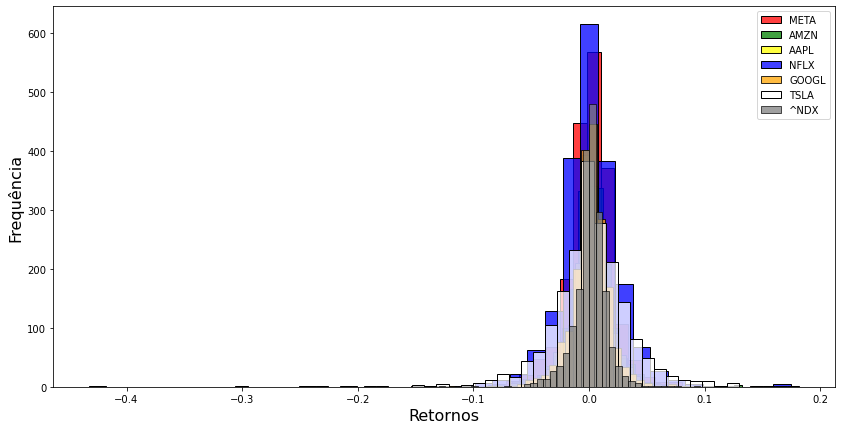

In [7]:
fig, ax = plt.subplots(figsize=(14,7))
ax = sns.histplot(taxas_retorno_date['META'], bins=40, label='META', color = 'red')
ax = sns.histplot(taxas_retorno_date['AMZN'], bins=40, label='AMZN', color='green')
ax = sns.histplot(taxas_retorno_date['AAPL'], bins=40, label='AAPL', color='yellow')
ax = sns.histplot(taxas_retorno_date['NFLX'], bins=40, label='NFLX', color='blue')
ax = sns.histplot(taxas_retorno_date['GOOGL'], bins=40, label='GOOGL', color='orange')
ax = sns.histplot(taxas_retorno_date['TSLA'], bins=40, label='TSLA', color='white')
ax = sns.histplot(taxas_retorno_date['^NDX'], bins=40, label='^NDX', color='gray')
ax.set_xlabel("Retornos",fontsize=16)
ax.set_ylabel("Frequência",fontsize=16)
plt.legend()

Com esses dados, poderemos checar as condições para saber se o teste ANOVA é viável.

## Teste da variâncias homologêneas ou homocedasticidade

Uma das premissas para realizar o teste da ANOVA é que as variâncias das amostras sejam homogêneas, ou seja:

$$
\sigma _{1}^2 = \sigma _{2}^2 =... = \sigma _{n}^2
$$

Para isso, existem dois tipos de teste para verificar essa homocedasticidade: O Teste de Levene e o Teste de Barlet.


### Teste de Levene

O Teste de Levene é uma estatística inferencial usada para avaliar a igualdade de variâncias de uma variável calculada para dois ou mais grupos. Ele testa a hipótese nula de que as variâncias populacionais são iguais (chamada de homogeneidade de variância ou homocedasticidade). Se o valor-p resultante do teste de Levene for menor que algum nível de significância (normalmente 0,05), é improvável que as diferenças obtidas nas variâncias amostrais tenham ocorrido com base na amostragem aleatória de uma população com variâncias iguais. Assim, a hipótese nula de variâncias iguais é rejeitada e conclui-se que há diferença entre as variâncias na população.


Então, vamos verificar se as variâncias são iguais para a carteira e para o índice NASDAQ:


In [36]:
nivel_significancia = 0.05
tamanho_amostra = 1000
# amostraCarteira1 = np.array(taxas_retorno_port['CARTEIRA'].sample(n=tamanho_amostra, random_state=10))
# amostraCarteira2 = np.array(taxas_retorno_port['CARTEIRA'].sample(n=tamanho_amostra, random_state=11))
# amostraNASDAQ1 = np.array(taxas_retorno_port['^NDX'].sample(n=tamanho_amostra, random_state=10))
# amostraNASDAQ2 = np.array(taxas_retorno_port['^NDX'].sample(n=tamanho_amostra, random_state=11))
# amostraCarteira = taxas_retorno_port['CARTEIRA']
# amostraNasdaq = taxas_retorno_port['^NDX']
# estatistica_teste, p_valor = levene(amostraCarteira, amostraNasdaq)
amostraMeta =taxas_retorno_date['META']
amostraAmazon =taxas_retorno_date['AMZN']
amostraApple =taxas_retorno_date['AAPL']
amostraNetflix =taxas_retorno_date['NFLX']
amostraGoogle =taxas_retorno_date['GOOGL']
amostraTesla =taxas_retorno_date['TSLA']
amostraNasdaq =taxas_retorno_date['^NDX']
# estatistica_teste, p_valor = levene(amostraMeta, amostraAmazon, amostraApple, amostraNetflix, amostraGoogle, amostraTesla, amostraNasdaq)

def getAmostra(ativo):
    return taxas_retorno_date[ativo]

def testaLevene(ativo1, ativo2):
    amostra1 = getAmostra(ativo1)
    amostra2 = getAmostra(ativo2)
    # amostra1 = np.array(taxas_retorno_date[ativo1].sample(n=tamanho_amostra, random_state=10))
    # amostra2 = np.array(taxas_retorno_date[ativo2].sample(n=tamanho_amostra, random_state=10))

    estatistica_teste, p_valor = levene(amostra1, amostra2)
    print("Estatística-teste:",ativo1," x ", ativo2, estatistica_teste)
    print("P-valor:", p_valor)

    if p_valor <= nivel_significancia:
        print("Rejeita H0 - Variâncias não são iguais")
    else:
        print("Não Rejeita H0 - Variâncias são iguais")


# testaLevene('META', 'AMZN')
# testaLevene('META', 'AAPL')
# testaLevene('META', 'NFLX')
# testaLevene('META', 'GOOGL')
# testaLevene('META', 'TSLA')
# testaLevene('AMZN', 'AAPL')
# testaLevene('AMZN', 'NFLX')
# testaLevene('AMZN', 'GOOGL')
# testaLevene('AMZN', 'TSLA')
# testaLevene('AAPL', 'NFLX')
# testaLevene('AAPL', 'GOOGL')
# testaLevene('AAPL', 'TSLA')
# testaLevene('NFLX', 'GOOGL')
# testaLevene('NFLX', 'TSLA')
# testaLevene('GOOGL', 'TSLA')







,META,AMZN,AAPL,NFLX,GOOGL,TSLA,^NDX
META,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NFLX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GOOGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TSLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
^NDX,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
testaLevene('^NDX', 'META')
testaLevene('^NDX', 'AMZN')
testaLevene('^NDX', 'AAPL')
testaLevene('^NDX', 'NFLX')
testaLevene('^NDX', 'GOOGL')
testaLevene('^NDX', 'TSLA')

Estatística-teste: ^NDX  x  META 124.64046954049226
P-valor: 1.6750531728625053e-28
Rejeita H0 - Variâncias não são iguais
Estatística-teste: ^NDX  x  AMZN 108.25992543005432
P-valor: 5.070992458753041e-25
Rejeita H0 - Variâncias não são iguais
Estatística-teste: ^NDX  x  AAPL 77.45834074604002
P-valor: 2.016125859323476e-18
Rejeita H0 - Variâncias não são iguais
Estatística-teste: ^NDX  x  NFLX 278.9578597921126
P-valor: 1.680780732237671e-60
Rejeita H0 - Variâncias não são iguais
Estatística-teste: ^NDX  x  GOOGL 39.90450423187431
P-valor: 2.972575154184839e-10
Rejeita H0 - Variâncias não são iguais
Estatística-teste: ^NDX  x  TSLA 540.1674206594316
P-valor: 7.0185996266371295e-112
Rejeita H0 - Variâncias não são iguais


Com esse resultado, identificamos que a relação entre a Carteira e o índice NASDAQ não é homocedástica. Vamos confirmar essa suspeita com o Teste de Bartlett. Ele também tem como objetivo descartar a hipótese nula de que as variâncias são iguais:

In [38]:
stat_teste, p_valor = bartlett(getAmostra('CARTEIRA'), amostraNasdaq)
print(f"Estatística-teste: {stat_teste:0.4f}")
print(f"P-valor: {p_valor:0.4f}")

if p_valor <=nivel_significancia:
    print("Rejeita H0")
else:
    print("Não Rejeita H0")

NameError: name 'amostraCarteira' is not defined